# SNS Sentiment Analysis NN

Analyze social media texts and measure potential inflammatory / offensive language with a feedforward neural network.

In [269]:
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
import data_util as du
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers.legacy import Adam
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

# Load Data

Load preprocessed data, vocabulary included. 

In [145]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)
y_train = train[train.columns[1]].astype(int)
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)
y_test = test[test.columns[1]].astype(int)
print(X_test.shape, y_test.shape)

# Load vocabulary
vocabulary = ast.literal_eval(open("./datasets/processed/vocabulary.txt", "r").read())
print("Vocabulary size:", len(vocabulary))

(8000,) (8000,)
(2000,) (2000,)
Vocabulary size: 11560


In [146]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]
print("Lengths of train and test:", len(train_text), len(test_text))
print("train:test ratio:", len(train_text) / (len(train_text) + len(test_text)))
print("test:train ratio:", len(test_text) / (len(train_text) + len(test_text)))

Lengths of train and test: 8000 2000
train:test ratio: 0.8
test:train ratio: 0.2


# Vectorize data

In multinomial vectorization, we use it to calculate probabilities based on frequency of words from the vocabulary than whether the word has appeared at least once.

In [182]:
# Multinomial vectorizer, used to calculate probabilities based on vocabulary frequencies 
m_vectorizer = CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None)
X_train_m = m_vectorizer.fit_transform(train_text)
X_test_m = m_vectorizer.transform(test_text)

# Create a feedforward neural network then train it

Network has been tuned with different values for optimal results.

In [255]:
def create_ff_neural_network(X_training_data):
    model = Sequential([
        # Input layer
        # Input shape is also just vocabulary size
        Dense(units=256, input_dim=X_training_data.shape[1], activation='tanh'),
        Dropout(0.2),
        Dense(units=128, activation='tanh'),
        Dropout(0.2),
        Dense(units=64, activation='tanh'),
        Dropout(0.2),
        Dense(units=32, activation='tanh'),
        Dropout(0.2),
        # Output layer
        Dense(units=1, activation='sigmoid')
    ])
    
    # Legacy Adam
    opt = Adam(learning_rate=2e-5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [256]:
multinomial_model_ff = create_ff_neural_network(X_train_m)
multinomial_model_ff.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 256)               2959616   
                                                                 
 dropout_68 (Dropout)        (None, 256)               0         
                                                                 
 dense_109 (Dense)           (None, 128)               32896     
                                                                 
 dropout_69 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 64)                8256      
                                                                 
 dropout_70 (Dropout)        (None, 64)                0         
                                                                 
 dense_111 (Dense)           (None, 32)              

In [257]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [258]:
print("Multinomial Feedforward Neural Network:")

ff_history = multinomial_model_ff.fit(np.array(X_train_m.toarray()),
              np.array(y_train),
              epochs=10, batch_size=32,
              validation_data=(np.array(X_test_m.toarray()), np.array(y_test)),
              callbacks=[lr_callback])

Multinomial Feedforward Neural Network:
Epoch 1/10
250/250 [==============================] - 5s 16ms/step - loss: 0.6845 - accuracy: 0.5633 - val_loss: 0.6696 - val_accuracy: 0.6655 - lr: 2.0000e-05
Epoch 2/10
250/250 [==============================] - 3s 12ms/step - loss: 0.6575 - accuracy: 0.6628 - val_loss: 0.6381 - val_accuracy: 0.7055 - lr: 2.0000e-05
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.6163 - accuracy: 0.7226 - val_loss: 0.5960 - val_accuracy: 0.7210 - lr: 2.0000e-05
Epoch 4/10
250/250 [==============================] - 2s 10ms/step - loss: 0.5657 - accuracy: 0.7458 - val_loss: 0.5577 - val_accuracy: 0.7310 - lr: 2.0000e-05
Epoch 5/10
250/250 [==============================] - 2s 10ms/step - loss: 0.5155 - accuracy: 0.7659 - val_loss: 0.5330 - val_accuracy: 0.7390 - lr: 2.0000e-05
Epoch 6/10
250/250 [==============================] - 2s 10ms/step - loss: 0.4772 - accuracy: 0.7878 - val_loss: 0.5228 - val_accuracy: 0.7425 - lr: 1.8097e-05


In [ ]:
multinomial_model_ff.save('./models/sns_multinomial_ff.h5')
multinomial_model_ff.save('./models/sns_multinomial_ff.keras')

In [242]:
multinomial_model_ff = keras.models.load_model('./models/sns_multinomial.h5')

# Make predictions

In [260]:
def probs_to_preds(probabilities: list) -> list[int]:
    """
    Converts continuous (sigmoid) outputs to discrete binary probabilities
    :param probabilities: List of probabilities between [0, 1]
    :return: 
    """
    return [1 if p[0] > 0.5 else 0 for p in probabilities]

In [261]:
raw_predictions_ff = multinomial_model_ff.predict(X_test_m.toarray())
preds_ff = probs_to_preds(raw_predictions_ff)

63/63 [==============================] - 0s 2ms/step


In [262]:
_, _, _, _ = du.get_prfa(y_test, preds_ff, verbose=True)

Precision: 0.718139534883721
Recall: 0.7774420946626385
F1 Score: 0.746615087040619
Accuracy: 0.738


In [263]:
def predict_inflammatory_level(model: Sequential, text):
    # Vectorize the input text
    X_input = m_vectorizer.transform([text])
    
    # Get the prediction from the trained model
    prediction = model.predict(X_input.toarray())
    
    # The output is a probability value between 0 and 1
    inflammatory_level = prediction[0][0]
    
    return inflammatory_level

In [266]:
# Example of predicting inflammatory text with a probability
print(predict_inflammatory_level(multinomial_model_ff, "test text"))

1/1 [==============================] - 0s 13ms/step
0.23211196


# Plot history

<Figure size 500x800 with 0 Axes>

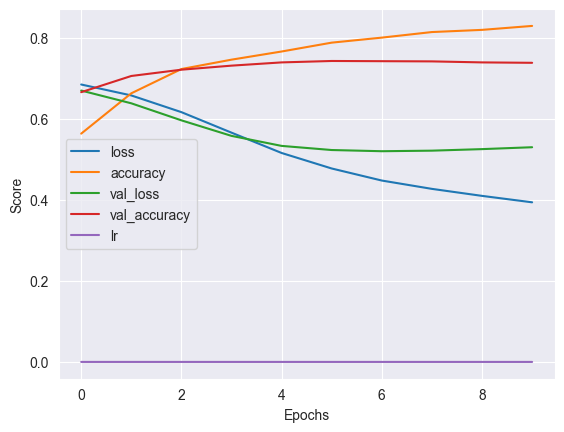

In [271]:
plt.figure(figsize=(5, 8))
pd.DataFrame(ff_history.history).plot()
plt.savefig('./graphs/ff_history.png')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.show()